In [426]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [401]:
#creating dataframes for both super and non-super foods
superfoods_df = pd.read_csv("superfoods_tagged.csv")
foods_df = pd.read_csv("Foods_tagged.csv")

# ADDED: Drop existing superfood column if it exists (it's likely full of NaN)
if 'superfood' in superfoods_df.columns:
    superfoods_df = superfoods_df.drop(columns=['superfood'])
if 'superfood' in foods_df.columns:
    foods_df = foods_df.drop(columns=['superfood'])

#dropping all columns that don't exist in both dataframes
columns_to_drop = superfoods_df.columns.difference(foods_df.columns)
superfoods_df = superfoods_df.drop(columns=columns_to_drop)

columns_to_drop = foods_df.columns.difference(superfoods_df.columns)
foods_df = foods_df.drop(columns=columns_to_drop)

# creating a 'superfood' feature
# CHANGED: Use 1/0 instead of True/False to avoid dtype issues
superfoods_df["superfood"] = 1
foods_df["superfood"] = 0

#combining the dataframes into one
df = pd.concat([superfoods_df, foods_df], ignore_index=True)

## Model 1: Perceptron 

In [403]:
# Define the feature columns
feature_columns = ['Total lipid (fat) (G)', 'Fatty acids, total saturated (G)', 'Fatty acids, total trans (G)', 'Cholesterol (MG)',
                   'Carbohydrate, by difference (G)', 'Fiber, total dietary (G)', 'Total Sugars (G)', 'Protein (G)', 'Vitamin D (D2 + D3) (UG)',
                   'Calcium, Ca (MG)', 'Iron, Fe (MG)', 'Potassium, K (MG)', 'Sodium, Na (MG)']

# Drop rows with any NaN values in the feature columns or the 'superfood' column
# This ensures that both X and y will be clean
df_cleaned = df.dropna(subset=feature_columns + ['superfood'])

print(df_cleaned.shape)
# standardize feature columns
for feat in df_cleaned.columns:
    if feat in feature_columns:
        df_cleaned[f'{feat}'] = (df_cleaned[feat] - df_cleaned[feat].mean()) / df_cleaned[feat].std()

# using required macronutrients as x features from the cleaned dataframe
x = [df_cleaned[col] for col in feature_columns]

(2081, 158)


/var/folders/sr/n9s7rlf93f7czt6_x1yj4x240000gn/T/ipykernel_93590/20967488.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [406]:
X = np.vstack([np.ones(len(x[0])), x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12]]).T
y = [1 if super_food else -1 for super_food in df_cleaned['superfood']]
w = np.array([1, -1, 0, -2, 1, 2, 1, 2, 1, -1, 0, -1, 1, 0])

In [408]:
def linear_perceptron(X, y, w, alpha = 1, max_iter = None):
    """
    calculate and return the final weight vector of a perceptron algorithm

    Args:
    - X (np array): a 2d-array (including bias column of 1s) with columns equal to  𝑥  features
    - y (np array): a 1d-array of labels (-1 or 1)
    - w (np array): an initial w vector of same dimension as the columns of X
    - alpha (int): the learning rate, with default value of 1
    - max_iter (int): the maximum number of iterations for the algorithm to run, with default value of None

    Returns:
    - w (np array): final weight vector
    """
    runalg = True
    i = 0
    iter = 0

    # ADDED - Initialize tracking lists
    accuracies = []
    misclassifications = []
    
    while runalg:

        pred = 0
        # for the current i, make the prediction
        obs = np.dot(X[i,:], w)
        if obs >= 0:
          pred = 1
        else:
          pred = -1
        # check if it is correct
        if pred != y[i]:
          # if not, update w
          w = w - alpha*(-y[i]*X[i,:])
        # add one to i
        i += 1
        # if you've just updated the last i (the last observation in the data), add one to iter
        if i == len(y):
            
          # ADDED - Calculate metrics at end of each epoch
          predictions = np.where(X @ w >= 0, 1, -1)
          accuracy = np.mean(predictions == y)
          misclass = np.sum(predictions != y)
          accuracies.append(accuracy)
          misclassifications.append(misclass)
            
          iter += 1
          i = 0
        # if you've set a max_iter, and if you've REACHED the max_iter, set runalg = False, print w and iter, and break
        if iter == max_iter:
          runalg = False
          print(iter)
          print(w)

    # CHANGED THIS LINE - Return all three values
    return w, accuracies, misclassifications

In [410]:
fin_w, accuracies, misclass = linear_perceptron(X, y, w, 0.0001, 1000)
print(fin_w) 

1000
[-1.11730000e+00  9.92166996e-03 -3.82777377e-03 -1.25382784e+00
  4.98108555e-02  3.87253622e-03  1.86033140e-03 -2.66089900e-03
 -1.49818256e-02 -8.80910330e-01  3.36773493e-03  1.22254791e-02
 -2.20106938e-03  6.60137298e-04]
[-1.11730000e+00  9.92166996e-03 -3.82777377e-03 -1.25382784e+00
  4.98108555e-02  3.87253622e-03  1.86033140e-03 -2.66089900e-03
 -1.49818256e-02 -8.80910330e-01  3.36773493e-03  1.22254791e-02
 -2.20106938e-03  6.60137298e-04]


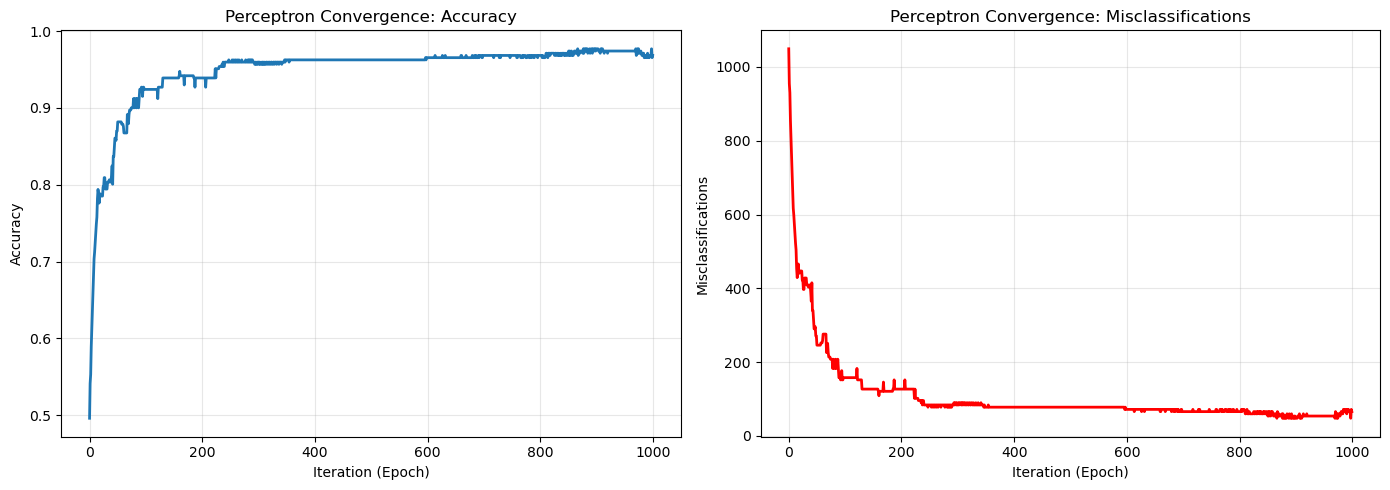

In [411]:
# CONVERGENCE PLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(range(len(accuracies)), accuracies, linewidth=2)
ax1.set_xlabel('Iteration (Epoch)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Perceptron Convergence: Accuracy')
ax1.grid(True, alpha=0.3)

# Misclassifications plot
ax2.plot(range(len(misclass)), misclass, color='red', linewidth=2)
ax2.set_xlabel('Iteration (Epoch)')
ax2.set_ylabel('Misclassifications')
ax2.set_title('Perceptron Convergence: Misclassifications')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

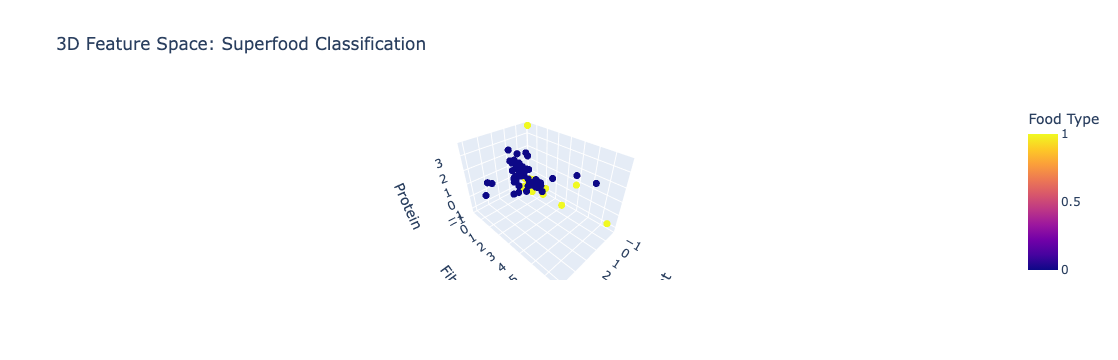

In [412]:
# 3D FEATURE PROJECTION

fig = px.scatter_3d(df_cleaned, 
                    x='Total lipid (fat) (G)', 
                    y='Fiber, total dietary (G)', 
                    z='Protein (G)',
                    color='superfood',
                    color_discrete_map={True: 'orange', False: 'blue'},
                    labels={'superfood': 'Food Type',
                            'Total lipid (fat) (G)': 'Total Fat',
                            'Fiber, total dietary (G)': 'Fiber',
                            'Protein (G)': 'Protein'},
                    title='3D Feature Space: Superfood Classification',
                    opacity=0.7)

fig.update_traces(marker=dict(size=4))
fig.show()

In [418]:
# Perceptron predictions (these variables should already exist in this notebook)
perceptron_preds = np.where(X @ fin_w >= 0, 1, -1)
perceptron_preds_binary = np.where(perceptron_preds == 1, 1, 0)
y_perceptron = np.array([1 if label == 1 else 0 for label in y])  # y from perceptron

# Create perceptron confusion matrix
cm_perceptron = confusion_matrix(y_perceptron, perceptron_preds_binary)

# Print for now (we'll compare with KNN later)
print("Perceptron Confusion Matrix:")
print(cm_perceptron)
print(f"\nTrue Negatives: {cm_perceptron[0,0]}")
print(f"False Positives: {cm_perceptron[0,1]}")
print(f"False Negatives: {cm_perceptron[1,0]}")
print(f"True Positives: {cm_perceptron[1,1]}")

Perceptron Confusion Matrix:
[[1925    0]
 [  66   90]]

True Negatives: 1925
False Positives: 0
False Negatives: 66
True Positives: 90


## Model 2: KNN Classifier 

In [380]:
y = df["superfood"].values
X = df.drop(columns=["superfood"])
X = X.select_dtypes(include=[np.number]).values

In [381]:
# train test split (70/30)
np.random.seed(1)
indices = np.arange(len(X))
np.random.shuffle(indices)

train_size = int(0.7 * len(X))
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [387]:
# min-max scaling
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)
X_range = np.where(X_max - X_min == 0, 1, X_max - X_min)

X_train_scaled = (X_train - X_min) / X_range
X_test_scaled = (X_test - X_min) / X_range

In [389]:
# KNN classifier
def knn_predict(X_train, y_train, x_test, k = 5):
    distances = np.sqrt(np.sum((X_train - x_test)**2, axis=1))
    k_idx = np.argsort(distances)[:k]
    
    return int(y_train[k_idx].mean() >= 0.5)

def knn_predict_batch(X_train, y_train, X_test, k = 5):
    return np.array([knn_predict(X_train, y_train, x, k) for x in X_test])

In [391]:
# evaluates accuracy
k = 5
preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k)
accuracy = (preds == y_test).mean()

print(f"KNN Accuracy (k={k}, 70/30 split): {accuracy:.3f}")

KNN Accuracy (k=5, 70/30 split): 0.813


k=1: Accuracy = 0.8127, Superfoods predicted = 0
k=3: Accuracy = 0.8127, Superfoods predicted = 0
k=5: Accuracy = 0.8127, Superfoods predicted = 0
k=7: Accuracy = 0.8127, Superfoods predicted = 0
k=10: Accuracy = 0.8127, Superfoods predicted = 0
k=15: Accuracy = 0.8127, Superfoods predicted = 0
k=20: Accuracy = 0.8127, Superfoods predicted = 0


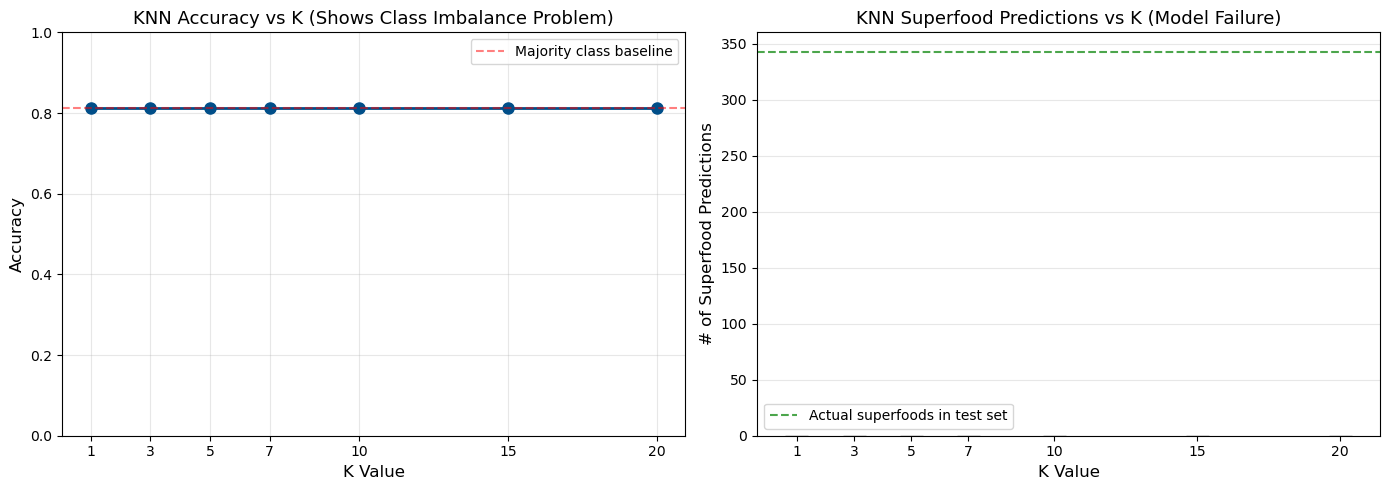

In [392]:
# K-VALUE OPTIMIZATION

# Test different k values and track predictions
k_values = [1, 3, 5, 7, 10, 15, 20]
accuracies = []
superfood_predictions = []

for k in k_values:
    preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k)
    accuracy = (preds == y_test).mean()
    superfood_pred_count = np.sum(preds == 1)
    
    accuracies.append(accuracy)
    superfood_predictions.append(superfood_pred_count)
    print(f"k={k}: Accuracy = {accuracy:.4f}, Superfoods predicted = {superfood_pred_count}")

# Create subplot with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy 
ax1.plot(k_values, accuracies, marker='o', linewidth=2, markersize=8, color='#004E89')
ax1.axhline(y=0.8127, color='red', linestyle='--', alpha=0.5, label='Majority class baseline')
ax1.set_xlabel('K Value', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('KNN Accuracy vs K (Shows Class Imbalance Problem)', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)
ax1.set_ylim([0, 1])
ax1.legend()

# Plot 2: Number of superfood predictions
ax2.bar(k_values, superfood_predictions, color='#FF6B35', alpha=0.7, edgecolor='black')
ax2.axhline(y=343, color='green', linestyle='--', alpha=0.7, label='Actual superfoods in test set')
ax2.set_xlabel('K Value', fontsize=12)
ax2.set_ylabel('# of Superfood Predictions', fontsize=12)
ax2.set_title('KNN Superfood Predictions vs K (Model Failure)', fontsize=13)
ax2.set_xticks(k_values)
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

The KNN failed on the imbalanced dataset, predicting zero superfoods regardless of k value. The 81.27% accuracy simply reflected the proportion of regular foods - the model was just guessing the majority class. 

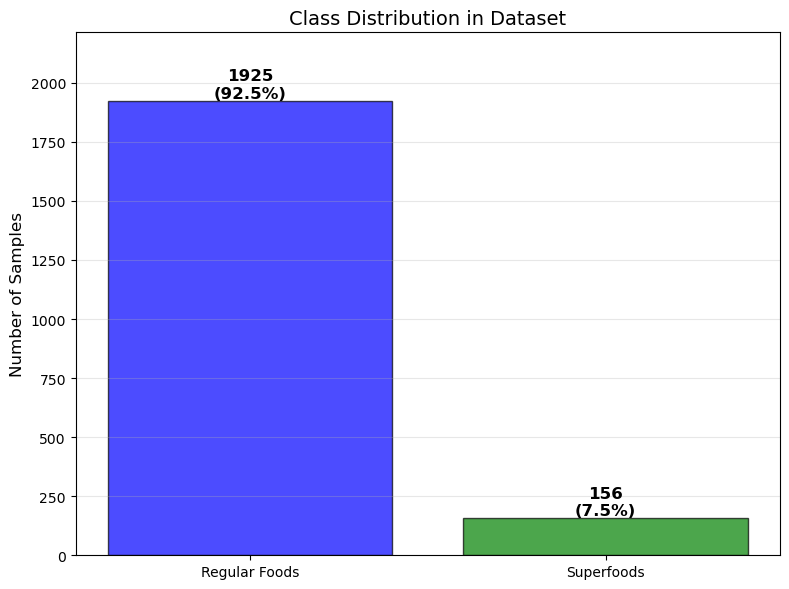

Total samples: 2081
Imbalance ratio: 12.34:1


In [395]:
# Count classes
superfood_count = df_cleaned['superfood'].sum()  # True = 1
regular_count = len(df_cleaned) - superfood_count

# Create bar chart
plt.figure(figsize=(8, 6))
classes = ['Regular Foods', 'Superfoods']
counts = [regular_count, superfood_count]
colors = ['blue', 'green']

bars = plt.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(df_cleaned)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14)
plt.ylim([0, max(counts) * 1.15])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total samples: {len(df_cleaned)}")
print(f"Imbalance ratio: {regular_count/superfood_count:.2f}:1")

## Model Comparison

/var/folders/sr/n9s7rlf93f7czt6_x1yj4x240000gn/T/ipykernel_93590/1276328560.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



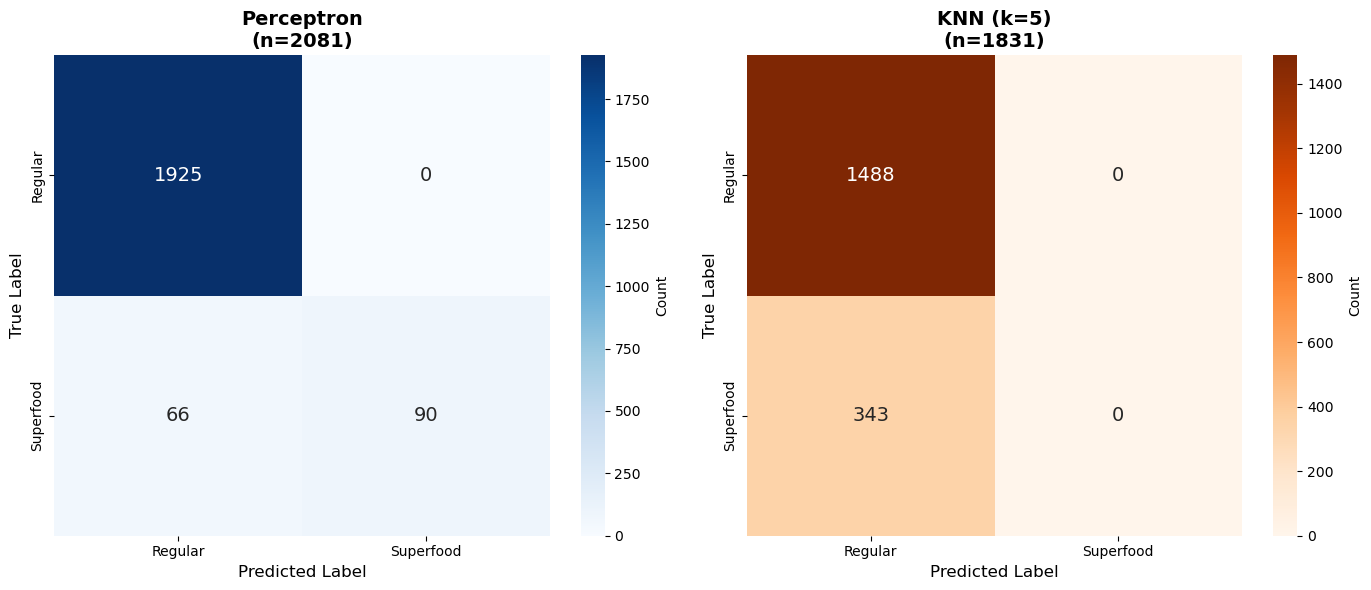


PERCEPTRON: 1925 0 66 90
KNN: 1488 0 343 0


In [440]:
# CONFUSION MATRICES

# Feature columns used in Perceptron
feature_columns_perceptron = [
    'Total lipid (fat) (G)', 'Fatty acids, total saturated (G)', 
    'Fatty acids, total trans (G)', 'Cholesterol (MG)',
    'Carbohydrate, by difference (G)', 'Fiber, total dietary (G)', 
    'Total Sugars (G)', 'Protein (G)', 'Vitamin D (D2 + D3) (UG)',
    'Calcium, Ca (MG)', 'Iron, Fe (MG)', 'Potassium, K (MG)', 'Sodium, Na (MG)'
]

# Get the cleaned df with only these features (no NaN)
df_perceptron = df.dropna(subset=feature_columns_perceptron + ['superfood'])

# Standardize features
for feat in feature_columns_perceptron:
    df_perceptron[feat] = (df_perceptron[feat] - df_perceptron[feat].mean()) / df_perceptron[feat].std()

# Create X matrix with bias column
x_features = [df_perceptron[col].values for col in feature_columns_perceptron]
X_perceptron = np.vstack([np.ones(len(df_perceptron)), *x_features]).T

# Create y vector
y_perceptron = df_perceptron['superfood'].values

# Get predictions
perceptron_preds = np.where(X_perceptron @ fin_w >= 0, 1, -1)
perceptron_preds_binary = np.where(perceptron_preds == 1, 1, 0)

# KNN predictions 
knn_preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k=5)

# Confusion matrices
cm_perceptron = confusion_matrix(y_perceptron, perceptron_preds_binary)
cm_knn = confusion_matrix(y_test, knn_preds)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Perceptron heatmap
sns.heatmap(cm_perceptron, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Regular', 'Superfood'],
            yticklabels=['Regular', 'Superfood'],
            cbar_kws={'label': 'Count'}, ax=axes[0], annot_kws={'size': 14})
axes[0].set_title(f'Perceptron\n(n={len(y_perceptron)})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# KNN heatmap
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Regular', 'Superfood'],
            yticklabels=['Regular', 'Superfood'],
            cbar_kws={'label': 'Count'}, ax=axes[1], annot_kws={'size': 14})
axes[1].set_title(f'KNN (k=5)\n(n={len(y_test)})', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nPERCEPTRON:", cm_perceptron[0,0], cm_perceptron[0,1], cm_perceptron[1,0], cm_perceptron[1,1])
print("KNN:", cm_knn[0,0], cm_knn[0,1], cm_knn[1,0], cm_knn[1,1])

PERFORMANCE METRICS COMPARISON
           Perceptron     KNN
Accuracy       0.9683  0.8127
Precision      1.0000  0.0000
Recall         0.5769  0.0000
F1-Score       0.7317  0.0000


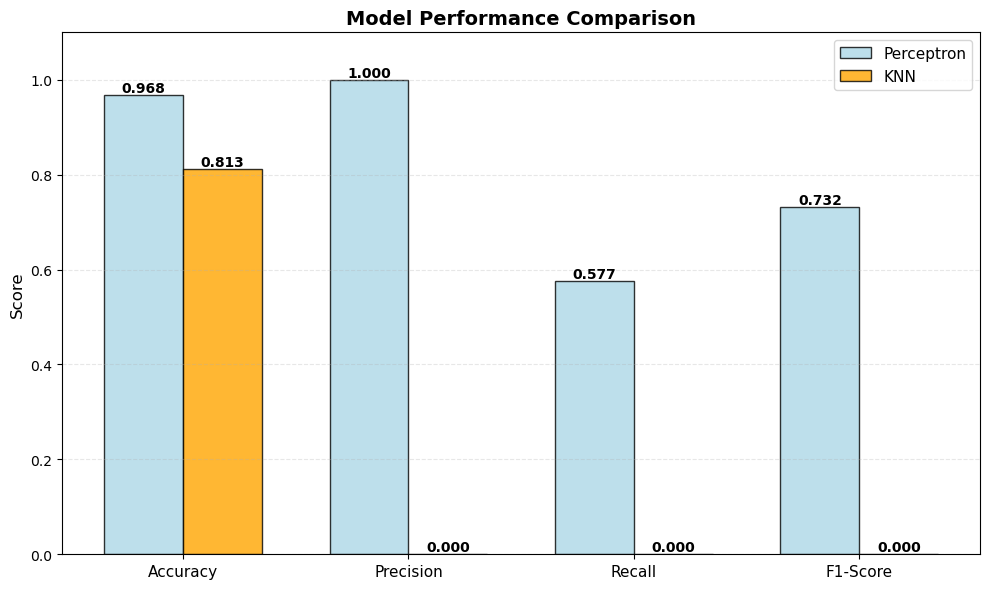

In [441]:
# PERFORMANCE METRICS TABLE/BAR CHART

perceptron_preds_binary = np.where(X @ fin_w >= 0, 1, 0)  # Make sure X and fin_w are from Perceptron
y_perceptron_binary = np.array([1 if label == 1 else 0 for label in y])  # Convert y to binary

perceptron_accuracy = accuracy_score(y_perceptron_binary, perceptron_preds_binary)
perceptron_precision = precision_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)
perceptron_recall = recall_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)
perceptron_f1 = f1_score(y_perceptron_binary, perceptron_preds_binary, zero_division=0)

# KNN metrics
knn_preds = knn_predict_batch(X_train_scaled, y_train, X_test_scaled, k=5)

knn_accuracy = accuracy_score(y_test, knn_preds)
knn_precision = precision_score(y_test, knn_preds, zero_division=0)
knn_recall = recall_score(y_test, knn_preds, zero_division=0)
knn_f1 = f1_score(y_test, knn_preds, zero_division=0)

# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Perceptron': [perceptron_accuracy, perceptron_precision, perceptron_recall, perceptron_f1],
    'KNN': [knn_accuracy, knn_precision, knn_recall, knn_f1]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("PERFORMANCE METRICS COMPARISON")
print(metrics_df.round(4))

# bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_df.index))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_df['Perceptron'], width, 
               label='Perceptron', color='lightblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, metrics_df['KNN'], width,
               label='KNN', color='orange', alpha=0.8, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, fontsize=11)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()